<a href="https://colab.research.google.com/github/Alisonia/Generative-adversarial-network/blob/main/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks of MNIST Handwritten Image Dataset**

## Step 1 Import the Neccesary Packages

In [ ]:
#loading the packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchvision.utils import save_image

## Step 2. Load the dataset

In [ ]:
# Dir to save the generated images
os.makedirs('gan_images', exist_ok=True)

# Image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
#MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

#Data loader
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15884379.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482162.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4403982.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6544324.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



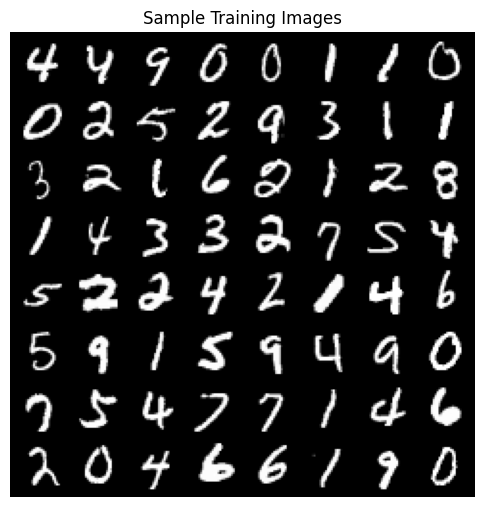

In [ ]:
#setting the device between GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#Ploting a few mnist training dataset
real_batch = next(iter(data_loader))
plt.figure(figsize=(6,10))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Step 3. Define Discriminator and Generator Networks

### *Discriminator*

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 7x7 -> 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 4x4 -> 2x2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0),  # 2x2 -> 1x1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x).view(-1, 1)

### *Generator*

In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=2, stride=1, padding=0), # 1x1 -> 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1), # 2x2 -> 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

## Step 4.	Define the loss functions for the discriminator and generator.


In [ ]:
#Binary cross entropy loss
criterion = nn.BCELoss()

## Step 5.	Define the optimizers for the discriminator and generator.

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0003)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0003)

## Step 6. Train the GAN

In [ ]:
num_epochs = 25
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, labels_real)

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, labels_fake)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        output = discriminator(fake_images)
        loss_g = criterion(output, labels_real)
        loss_g.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], '
                  f'Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

    # Save fake images generated by the generator
    fake_images = generator(fixed_noise)
    save_image(fake_images, f'gan_images/fake_images_{epoch+1}.png', normalize=True)

Epoch [1/25], Step [0/100], Loss D: 1.3816, Loss G: 3.3699
Epoch [2/25], Step [0/100], Loss D: 0.0003, Loss G: 9.1594
Epoch [3/25], Step [0/100], Loss D: 0.0002, Loss G: 9.3601
Epoch [4/25], Step [0/100], Loss D: 0.0001, Loss G: 10.6970
Epoch [5/25], Step [0/100], Loss D: 0.0001, Loss G: 10.6937
Epoch [6/25], Step [0/100], Loss D: 0.0000, Loss G: 10.9852
Epoch [7/25], Step [0/100], Loss D: 0.0000, Loss G: 10.6517
Epoch [8/25], Step [0/100], Loss D: 0.0000, Loss G: 11.2929
Epoch [9/25], Step [0/100], Loss D: 0.0000, Loss G: 11.0417
Epoch [10/25], Step [0/100], Loss D: 0.0000, Loss G: 11.5716
Epoch [11/25], Step [0/100], Loss D: 0.0000, Loss G: 11.7327
Epoch [12/25], Step [0/100], Loss D: 0.0000, Loss G: 11.8640
Epoch [13/25], Step [0/100], Loss D: 0.0000, Loss G: 11.6442
Epoch [14/25], Step [0/100], Loss D: 0.0000, Loss G: 12.1180
Epoch [15/25], Step [0/100], Loss D: 0.0000, Loss G: 11.8664
Epoch [16/25], Step [0/100], Loss D: 0.0000, Loss G: 11.9676
Epoch [17/25], Step [0/100], Loss D:

## Step 7. Evaluate the GAN

In [ ]:
# Function to evaluate the discriminator on real and fake images
def evaluate_discriminator(discriminator, dataloader, generator, device):
    discriminator.eval()
    real_score = 0.0
    fake_score = 0.0
    with torch.no_grad():
        for real_images, _ in dataloader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            labels_real = torch.ones(batch_size, 1).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)

            output_real = discriminator(real_images)
            real_score += output_real.mean().item()

            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images)
            fake_score += output_fake.mean().item()

    real_score /= len(dataloader)
    fake_score /= len(dataloader)
    return real_score, fake_score

real_score, fake_score = evaluate_discriminator(discriminator, data_loader, generator, device)
print(f'Discriminator Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}')


Discriminator Real Score: 0.7735, Fake Score: 0.0002


## Step 8. Save the final real and fake image sets

In [ ]:
real_images, _ = next(iter(data_loader))
save_image(real_images, 'gan_images/real_images.png', nrow=8, normalize=True)
fake_images = generator(fixed_noise)
save_image(fake_images, 'gan_images/fake_images_final.png', nrow=8, normalize=True)

## Step 9: Save the discriminator and generator models

In [ ]:
torch.save(generator.state_dict(), 'generator.ckpt')
torch.save(discriminator.state_dict(), 'discriminator.ckpt')